In [49]:
import numpy as np
from pandas import read_csv
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

In [50]:
def read_data():
    return read_csv('./data/SA_heart.csv')

In [51]:
def clean_data(dataset):
    dataset['famhist'].replace({"Present": 1, "Absent": 0}, inplace=True)

In [52]:
# Collect and parse dataset
dataset = read_data()
clean_data(dataset)

# Drop not variables columns
variables_dataset_with_label = dataset.drop('id', axis=1)
variables_dataset = variables_dataset_with_label.drop('chd', axis=1)

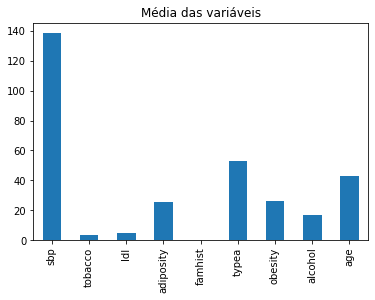

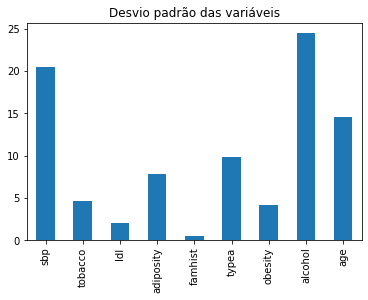

In [53]:
# 1. Mean and std from every variable

# Calculate mean and std
describe = variables_dataset.describe()
variables_mean = describe.T['mean']
variables_std = describe.T['std']

# Plot mean and std
variables_mean.plot(kind='bar', title='Média das variáveis')
pyplot.show()
variables_std.plot(kind='bar', title='Desvio padrão das variáveis')
pyplot.show()

In [54]:
# Improves variables name for model evaluate
x = variables_dataset
y = variables_dataset_with_label.loc[:, 'chd']
n_features = len(variables_dataset.columns.values)

In [55]:
# Setup models
models = [
    ('CART', DecisionTreeClassifier()),  # 2. Prediction with CART
    ('RandomForest', RandomForestClassifier(n_estimators=100)),  # 3. Prediction with RandomForest
    ('RandomForest SQRT', RandomForestClassifier(max_features="sqrt", n_estimators=100))  # 4. RandomForest Sqrt
]

In [56]:
# Setup best case and models_output
best_case = {
    "fold_number": 0,
    "area": 0,
    "model_name": "",
    "features": [],
}

models_output = {
    "CART": dict(),
    "RandomForest": dict(),
    "RandomForest SQRT": dict()
}

# Setup Kfold
k_fold = KFold(n_splits=10, random_state=1, shuffle=True)

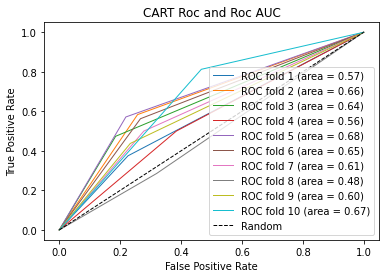

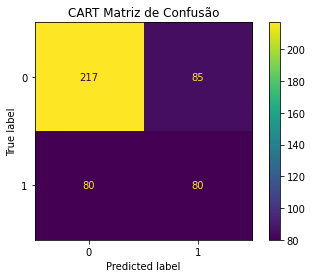

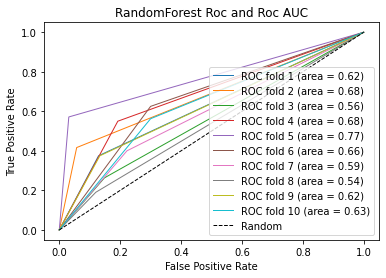

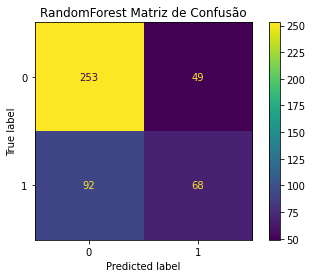

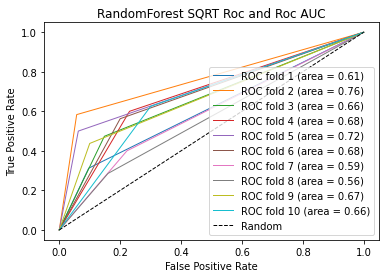

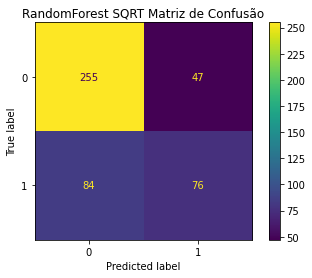

In [57]:
# Steps 2, 3, 4 - Evaluate models
for name, model in models:
    confusion_matrixs = []
    fold_index = 0

    # Initialize models output
    models_output[name]["auc"] = 0
    models_output[name]["features"] = np.zeros(n_features)

    pyplot.figure()
    for train_ix, test_ix in k_fold.split(x, y):
        train_x, train_y, test_x, test_y = x.iloc[train_ix], y.iloc[train_ix], x.iloc[test_ix], y.iloc[test_ix]

        clf = model.fit(train_x, train_y)
        predicted_labels = clf.predict(test_x)

        # Roc curve variables
        fpr, tpr, _ = roc_curve(test_y, predicted_labels, pos_label=1)
        roc_auc = auc(fpr, tpr)
        models_output[name]["auc"] += roc_auc
        pyplot.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (fold_index + 1, roc_auc))

        # Confusion matrix
        confusion_matrixs.append(confusion_matrix(test_y, predicted_labels))

        # Save features performance
        models_output[name]["features"] = np.add(models_output[name]["features"], clf.feature_importances_)

        # Select best case bases on AOC area
        if roc_auc > best_case["area"]:
            best_case = {
                "fold_number": fold_index + 1,
                "model_name": name,
                "area": roc_auc,
                "features": clf.feature_importances_
            }

        fold_index += 1

    # Roc curves plot
    pyplot.plot([0, 1], [0, 1], "k--", lw=1, label="Random")
    pyplot.legend(loc="lower right")
    pyplot.title(f'{name} Roc and Roc AUC')
    pyplot.xlabel("False Positive Rate")
    pyplot.ylabel("True Positive Rate")
    pyplot.show()

    # Confusion matrix plot
    confusion_matrixs_total = np.add.reduce(confusion_matrixs)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrixs_total)
    disp.plot()
    pyplot.title(f'{name} Matriz de Confusão')
    pyplot.show()

Best model in average RandomForest SQRT (0.733)
Best fold 5 from RandomForest (0.770)


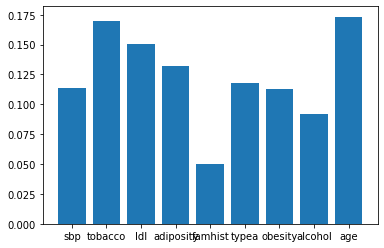

In [58]:
# 5. Best features for the best case (Choose highest aoc)
best_model = max(models_output, key=lambda k: models_output[k]["auc"])
print(f'Best model in average {best_model} ({(models_output[best_model]["auc"] / n_features):.3f})')
print(f'Best fold {best_case["fold_number"]} from {best_case["model_name"]} ({best_case["area"]:.3f})')
pyplot.figure()
pyplot.bar(variables_dataset.columns.values, (models_output[best_model]["features"] / n_features))
pyplot.show()